<a href="https://colab.research.google.com/github/Smartsie/Optimizer/blob/master/Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Optim package

# **Functionnalities to be added**
1.   Models should be listed in a dictionnary. Each model is defined by it's function or class with train, predict and score 
2.   During fitting, we will score all models. The highest score will then be used for the prediction
3. This could be done by doing a voting of top 3 best models with a 3,2,1 weight for instance
4. Models accuracy will evolve with time (DOF)
5. Evaluation of models done on X-validation
6. Add early stop 







In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [0]:
import plotly as py
from keras.layers import Dense
import lightgbm
import plotly.express as px

In [0]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
model = GaussianProcessRegressor(random_state=0)
#gpr.score(X, y)
#gpr.predict(X[:2,:], return_std=True)
# Define model that will be used to minimize the function
# Simple NN
import tensorflow.keras
from tensorflow.keras.models import Sequential
from xgboost import XGBRegressor
#def def_model():
    # define the keras model
    # it returns a compile model
#model = Sequential()
#model.add(Dense(5, input_dim=(2), activation='relu'))
    #model.add(Dense(4))
    #model.add(Dense(8, activation='relu'))
#model.add(Dense(1, activation='linear'))
#model.compile(loss='mae', optimizer='sgd', metrics=['accuracy'])
#   return model
#model=XGBRegressor()
#model=lightgbm.LGBMRegressor()

In [0]:
# If we want to export in html in a separate browser
import plotly.io as pio
#pio.renderers.default = "browser" 

In [0]:
α=1

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df=pd.read_csv('/content/drive/My Drive/Colab Data/Japan_XYZ_data.txt',header=None,delimiter=r"\s+")
df.columns=['x0','x1','z']
# Flip the data in z so that Mt Fuji is minimum
df['z']=-df['z']


In [0]:
# Resample the Dataframe to speed things up
# N=10000 --> we keep only 10000 points
N=500000
step=int(len(df)/N)
DF=df[::step]

In [102]:
print('Theoretical Minimum:')
print(DF.iloc[np.argmin(DF.z)])
minx0=DF.iloc[np.argmin(DF.z)][0]
minx1=DF.iloc[np.argmin(DF.z)][1]

Theoretical Minimum:
x0     138.7417
x1      35.3572
z    -3219.0000
Name: 1319400, dtype: float64


In [0]:
def eval_f(vector):
  x1std=DF['x0'].std()
  x2std=DF['x1'].std()
  mask1=np.abs(DF['x0']-vector[0])<x1std/4
  mask2=np.abs(DF['x1']-vector[1])<x2std/4
  a=DF[mask1&mask2]
  result=a['z'].min()
  return result

In [0]:
# Define function to minimize
def funct(x):
    x1=x[0]
    x2=x[1]
    #f=x1*x1+x1*x2+2*np.sin((x1+x2)*2)+4*np.cos(x2*2)
    f=x1*x1+x2*x2-x1*x2+20*np.sin(x1-x2)-8*np.cos(x2*2)
    #f=3*x1*x1-2*x2+5*x1/x2
    ## Lévi function
    #f=(np.sin(3*3.1415*x1))**2+(x1-1)**2*(1+(np.sin(3*3.1415*x2))**2)+(x2-1)**2*(1+(np.sin(2*3.1415*x2))**2)
    # For Japan map f=eval_f(x)
    return f

In [0]:
# Define function providing 5 points around 
def next_point(current_space,n=5):
    next_space=current_space
    pt=pd.DataFrame()
    for i in range(n):
        vecteur=current_space['Center']
        Radius=current_space['Radius']
        new_vec=vecteur+Radius*np.random.choice((-1,1),size=len(Radius))*(np.random.random(len(Radius)))
        for j in range(len(new_vec)):
            if new_vec[j]<space.iloc[j]['Center']-space.iloc[j]['Radius']:
                new_vec[j]=space.iloc[j]['Center']-space.iloc[j]['Radius']
            if new_vec[j]>space.iloc[j]['Center']+space.iloc[j]['Radius']:
                new_vec[j]=space.iloc[j]['Center']+space.iloc[j]['Radius']                              
        pt['n'+str(i)]=new_vec
    pt=pt.T
    pt.columns=X.drop('z',axis=1).columns
    #next_space['Radius']=next_space['Radius']*epsilon
    return pt
        

In [0]:
# This function adds the points to the matrix
# The matrix is a dataframe
def add_matrix(X,points):
    df=points
    for i in range(len(df)):
        variables=df.iloc[i]
        variables['z']=funct(variables)
        X=X.append(variables)
    return X

In [0]:
def training_loop(X,domain,AI=False,n=5,epsilon=0.95):
    df=next_point(domain,n)
    Matrix=add_matrix(X,df)
    x=Matrix.drop('z',axis=1).values
    y=Matrix['z'].values
    if AI==True:
        #model.fit(x,y,epochs=100,verbose=False)
        # Need to do a CV split with Train test split
        models={LinearRegression(),XGBRegressor(objective ='reg:squarederror'), MLPRegressor(hidden_layer_sizes=(5,3)), lightgbm.LGBMRegressor(),GaussianProcessRegressor(random_state=0)}
        X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.8,shuffle=True)
        r2max=-10
        best_model=LinearRegression()
        for model_loop in models:
          model_loop.fit(X_train,y_train)
          r2=model_loop.score(X_test,y_test)
          if r2>r2max:
            r2max=r2
            best_model=model_loop
        model=best_model
        # Retrain the model with all data
        model.fit(x,y)
        # Predict and find the minimum in one shot
        Prediction=model.predict(srf_x.values)
        lowest_value=np.min(Prediction)
        minimum=srf.iloc[np.argmin(Prediction)]    
        # Evaluate at minimu
        lowest_value=funct(minimum.values)    
        if r2max<0.4:
          print('R2 insufficient %0.2f'%r2max)
          theor_min=np.argmin(X.z.values)
          lowest_value=np.min(X.z.values)
          minimum=X.iloc[theor_min]
        #else:
        #    print("Model found with r2=%0.2f"%r2max)
    else:
        theor_min=np.argmin(X.z.values)
        lowest_value=np.min(X.z.values)
        minimum=X.iloc[theor_min]
    minimum=minimum.drop('z')
    # New space should be centered around this minimum
    domain['Center']=(minimum.values*0.5+domain.Center*0.5)
    domain['Radius']=domain['Radius']*epsilon
    return Matrix,domain,lowest_value

In [0]:
  # Define the desX_ign space as center point with radius
x0range=[-10,10]
x1range=[-10,10]

 # for japan x0range=[DF.x0.min(),DF.x0.max()]
 # x1range=[DF.x1.min(),DF.x1.max()]

space=pd.DataFrame(columns=['Center','Radius'])
space.loc[0]=[np.mean(x0range),0.5*(x0range[1]-x0range[0])]
space.loc[1]=[np.mean(x1range),0.5*(x1range[1]-x1range[0])]
# Initialize X matrix
X=pd.DataFrame()
for i in range(len(space)):
    X['x'+str(i)]=0
X['z']=0
# Fill X with 5 points
X['x0']=[x0range[0],x0range[0],x0range[1],x0range[1],(x0range[0]+x0range[1])/2,(x0range[0]+x0range[1])/2,(x0range[0]+x0range[1])/2,x0range[0],x0range[1]]
X['x1']=[x1range[0],x1range[1],x1range[0],x1range[1],(x1range[0]+x1range[1])/2,x1range[0],x1range[1],(x1range[0]+x1range[1])/2,(x1range[0]+x1range[1])/2]
for i in range(len(X)):
    variables=X.iloc[i]
    #variables['target']=funct(variables[['x0','x1']].values)
    tgt=funct(variables.values)
    X.iloc[i]['z']=tgt

# Initialize domain
domain=space.copy()

# Initialize Evaluation surface
N=100
srf=[]
loc=0
for i in np.linspace(x0range[0],x0range[1],N):
  for j in np.linspace(x1range[0],x1range[1],N):
    vector=[i,j,funct([i,j])]
    srf.append(vector)
srf=pd.DataFrame(srf,columns=['x0','x1','z'])
# for japan srf=DF
srf_x=srf.drop(['z'],axis=1)


In [331]:
fig = px.scatter_3d(srf, x='x0', y='x1', z='z',color='z')
fig.show()
print("Minimum : ",np.min(srf.z))
print(srf.iloc[np.argmin(srf.z)])
minx0=srf.iloc[np.argmin(srf.z)][0]
minx1=srf.iloc[np.argmin(srf.z)][1]


Minimum :  -25.72524324258832
x0    -1.313131
x1     0.101010
z    -25.725243
Name: 4350, dtype: float64


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



R2 insufficient -0.13


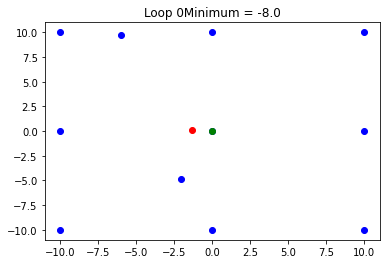

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



R2 insufficient -1.58


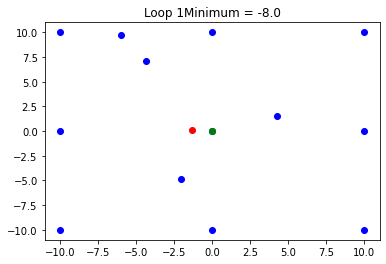

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



R2 insufficient -0.61


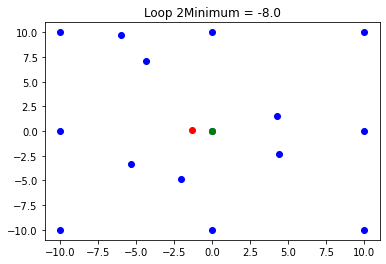

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



R2 insufficient -0.00


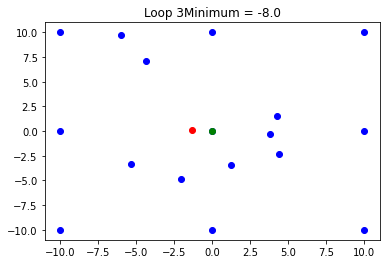

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



R2 insufficient -0.88


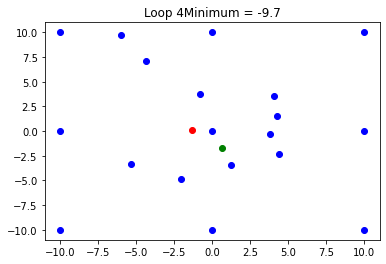

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



R2 insufficient -0.13


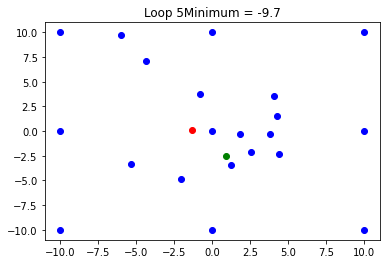

R2 insufficient -0.44


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



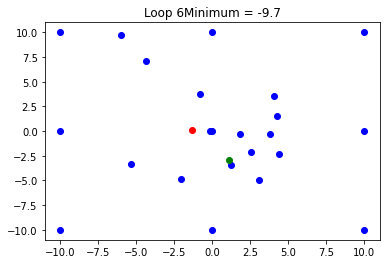

R2 insufficient 0.14


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



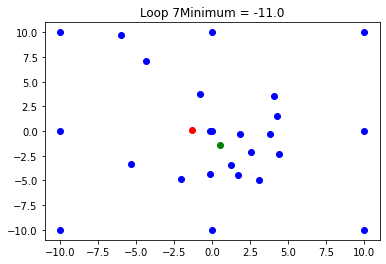

R2 insufficient -0.20


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



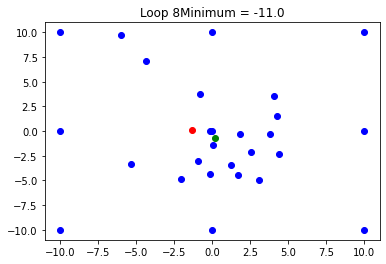

R2 insufficient -0.32


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



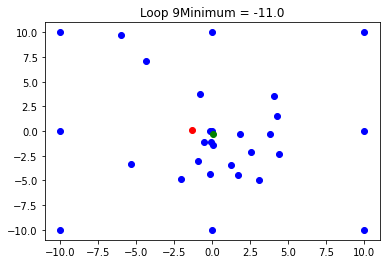

R2 insufficient -0.00


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



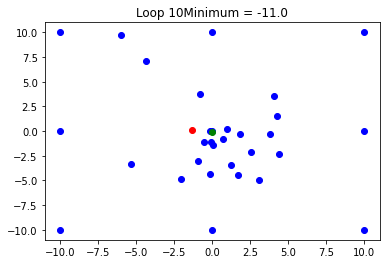

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



R2 insufficient -0.38


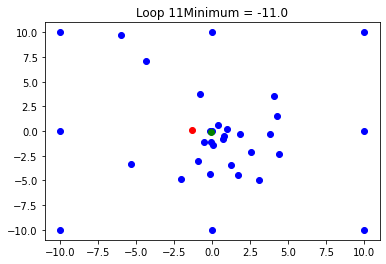

R2 insufficient 0.05


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



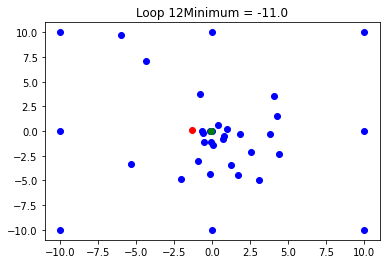

R2 insufficient -0.06


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



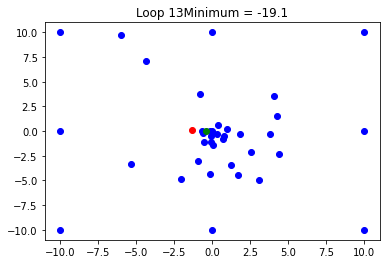

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



R2 insufficient -0.08


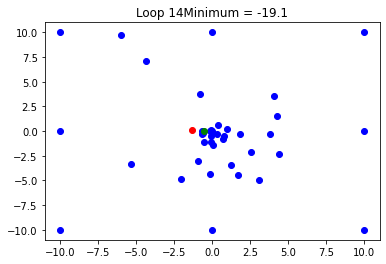

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



R2 insufficient 0.00


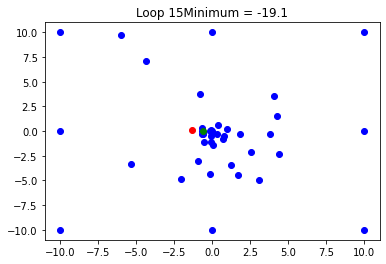

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



R2 insufficient 0.26


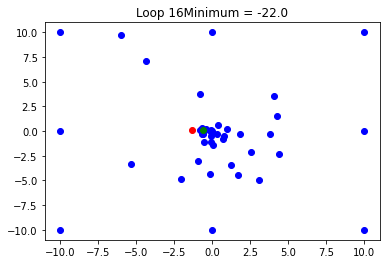

R2 insufficient -0.01


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



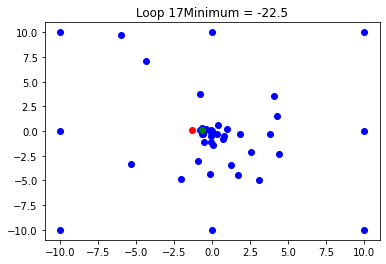

R2 insufficient -0.02


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



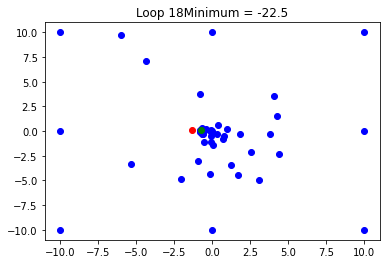

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



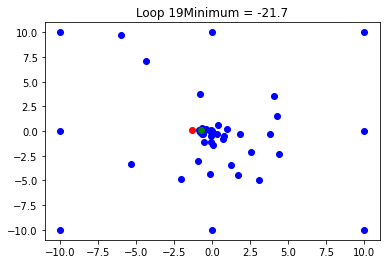

Trials: 49


In [332]:
# Run the training loop
N=20
Max_points=2
point_amount=Max_points
Dom=[] #pd.DataFrame(columns=['x0 C','x0 R','x1 C','x1 R'])]
for i in range(N):
    # Point amound should decrease. At the beginning, it should be 10. At the end, 2.
    #point_amount=np.int((Max_points-3)-(Max_points-3)*i/N)+3

    X,domain,minimum=training_loop(X,domain,AI=True,n=point_amount,epsilon=0.8)
    #print(i,minimum)
    #Dom=np.append(Dom,[i,domain.loc[0].values])
    vect=[i, domain.loc[0].values[0],domain.loc[0].values[1],domain.loc[1].values[0],domain.loc[1].values[1]]
    Dom.append(vect)
    plt.scatter(X['x0'],X['x1'],color='blue')
    plt.scatter(Dom[-1][1],  Dom[-1][3],color='green')
    plt.scatter(minx0,minx1,color='red')
    plt.title("Loop "+str(i)+ "Minimum = %0.1f"%minimum)
    plt.show()
    plt.pause(0.005)
Dom=pd.DataFrame(Dom,columns=['idx','x0 C','x0 R','x1 C','x1 R'])
print("Trials:", len(X))

In [333]:
# Print Minimum found
min=np.min(X.z.values)
print("Minimum found:")
print(X.iloc[np.argmin(X.z.values)])
print("Theoretical Minimum : ")
print(srf.iloc[np.argmin(srf.z)])


Minimum found:
x0    -0.850096
x1     0.114996
z    -23.397727
Name: n0, dtype: float64
Theoretical Minimum : 
x0    -1.313131
x1     0.101010
z    -25.725243
Name: 4350, dtype: float64


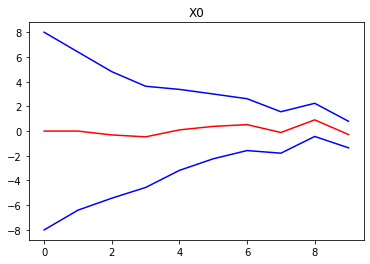

In [306]:
plt.plot(Dom.idx,Dom['x0 C'],color='red')
plt.plot(Dom.idx,Dom['x0 C']+Dom['x0 R'],color='blue')
plt.plot(Dom.idx,Dom['x0 C']-Dom['x0 R'],color='blue')
plt.title('X0')
plt.show()

We can see that that there is *stable* convergence on X0

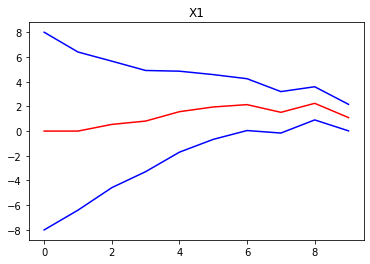

In [307]:
plt.plot(Dom.idx,Dom['x1 C'],color='red')
plt.plot(Dom.idx,Dom['x1 C']+Dom['x1 R'],color='blue')
plt.plot(Dom.idx,Dom['x1 C']-Dom['x1 R'],color='blue')
plt.title('X1')
plt.show()

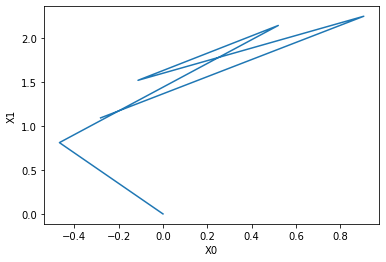

In [308]:
#plt.plot(Dom['x0 C'],Dom['x1 C'],color='red')
plt.plot(Dom['x0 C'],Dom['x1 C'])
plt.ylabel('X1')
plt.xlabel('X0')
plt.show()

However, X1 is **unstable** as it is bouncing abruptly

In [240]:
print('Theoretical Minimum')
print(DF.iloc[np.argmin(DF.z)])


Theoretical Minimum
x0     138.7417
x1      35.3572
z    -3219.0000
Name: 1319400, dtype: float64


Minimum found:
x0    -0.566349
x1    -1.756081
z    -10.038849
Name: n0, dtype: float64


In [242]:
print("Total Experiments")
print(len(X))

Total Experiments
49


In [243]:
Prediction=model.predict(srf_x.values)

XGBoostError: ignored

In [0]:
modelresult=srf_x.copy()
modelresult['target']=Prediction

In [0]:
fig = px.scatter_3d(modelresult, x='x0', y='x1', z='target',color='target',title='Model Result')
fig.show()

In [0]:
fig = px.scatter_3d(srf, x='x0', y='x1', z='target',color='target',title='Actual data')
fig.show()

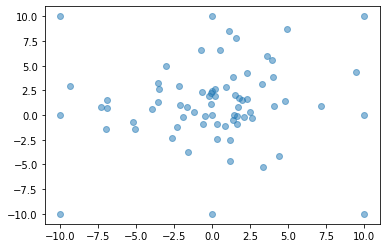

In [0]:
plt.scatter(X['x0'],X['x1'],alpha=0.5)

In [0]:
print("Theoretical minimum from surface")
print(srf.iloc[np.argmin(srf.z)])

Theoretical minimum from surface


AttributeError: ignored

In [0]:
# How to find minimum?
# 1 Define design space
x_space=[-5,5]
y_space=[-5,5]
# Define space Matrix
N_points=50*50
n=np.sqrt(N_points)
X_space=pd.DataFrame(columns=['x1','x2'])

In [0]:
def training_loop(current_x_space,current_y_space, AI=False):
    #def train_model(X,model):
    x=X[['x','y']].values
    y=X['z'].values
    if AI==True:
        #model.fit(x,y,epochs=100,verbose=False)
        model.fit(x,y)
        print('Model score',model.score(x,y))
        # find minimum in design space
        # Predict and find the minimum in one shot
        minimum=X_space.iloc[np.argmin(model.predict(X_space.values))]
    else:
        theor_min=np.argmin([funct(X_space.iloc[i][0],X_space.iloc[i][1]) for i in range(0,len(X_space))])
        minimum=X_space.iloc[theor_min]
    cx=np.mean(current_x_space)
    cy=np.mean(current_y_space)
    # focus point
    fx=minimum[0]
    fy=minimum[1]
    rangex=current_x_space[1]-current_x_space[0]
    rangey=current_y_space[1]-current_y_space[0]
    # divide the range by 2
    rangex=rangex/3
    rangey=rangey/3
    new_rangex=[(fx+cx)/2-rangex,(fx+cx)/2+rangex]
    new_rangey=[(fy+cy)/2-rangey,(fy+cy)/2+rangey]
#    new_rangey=[minimum[0]-rangey,minimum[0]+rangey]
    points=provide_point(new_rangex,new_rangey,noise=False)
    add_matrix(points)
    current_x_space=new_rangex
    current_y_space=new_rangey  
    return current_x_space,current_y_space

In [0]:
#Define Matrix of results
X=pd.DataFrame(columns=['x','y','z'])
points=provide_point(x_space,y_space,noise=False)
add_matrix(points)
points=provide_point(x_space,y_space,noise=True)
add_matrix(points)
current_x_space=x_space
current_y_space=y_space
print(X)

In [0]:
# Fin the best point by doing training
A=[]
B=[]
for i in range(0,10):
    current_x_space,current_y_space= training_loop(current_x_space,current_y_space,AI=True)
    A.append(current_x_space)
    B.append(current_y_space)

In [0]:
A=pd.DataFrame(A,columns=['xmin','xmax'])
B=pd.DataFrame(B,columns=['ymin','ymax'])
A.plot()
B.plot()
plt.show()
plt.plot(X.x,X.y)
plt.title('Convergence')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()
plt.show()

In [0]:
print("Theoretical minimum from surface")
print(srf.iloc[np.argmin(srf.z)])
# Calculate min value of X
theor=np.argmin(X.z.values)
minimum=X.iloc[theor]
print("Estimated minimum by solver:")
print(minimum)

In [0]:
X_space['z']=model.predict(X_space[['x1','x2']].values)

In [0]:
fig1 = px.scatter_3d(srf, x='x1', y='x2', z='z')
fig2 = px.scatter_3d(X_space, x='x1', y='x2', z='z',color='z')
fig2.show()

In [0]:
fig1 = px.scatter_3d(srf, x='x1', y='x2', z='z',color='z')
fig1.show()

In [0]:
trace1 = go.Scatter3d(
    x=srf.x1,
    y=srf.x2,
    z=srf.z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217,0 , 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)




In [0]:
trace2 = go.Scatter3d(
    x=X_space.x1,
    y=X_space.x2,
    z=X_space.z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(0, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)


In [0]:
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [0]:
import chart_studio.plotly as py

In [0]:
fig = go.Figure(data=[go.Scatter3d(x=X.x.values, y=X.y.values, z=X.z.values,
                                   mode='markers')])
fig.show()

In [0]:
fig = px.scatter_3d(srf, x='x1', y='x2', z='z',color='z')


fig.show()

In [0]:
fig = px.scatter_3d(X_space, x='x1', y='x2', z='z',color='z')


fig.show()